In [1]:
import numpy as np
import pandas as pd


In [2]:
import os

In [3]:
base_data_dir = '/kaggle/input/alzheimer/alzheimer'
train_base_dir = f'{base_data_dir}/train'
test_base_dir = f'{base_data_dir}/test'

In [4]:
class_distributions = {}
classes = os.listdir(train_base_dir)

In [5]:
for class_name in classes:
    class_distributions[class_name] = len(os.listdir(f'{train_base_dir}/{class_name}'))

In [6]:
class_distributions

{'ModerateDemented': 52,
 'NonDemented': 2560,
 'VeryMildDemented': 1792,
 'MildDemented': 717}

In [7]:
from matplotlib import pyplot as plt

#### Distribution of classes in the train dataset

([0, 1, 2, 3],
 [Text(0, 0, 'ModerateDemented'),
  Text(1, 0, 'NonDemented'),
  Text(2, 0, 'VeryMildDemented'),
  Text(3, 0, 'MildDemented')])

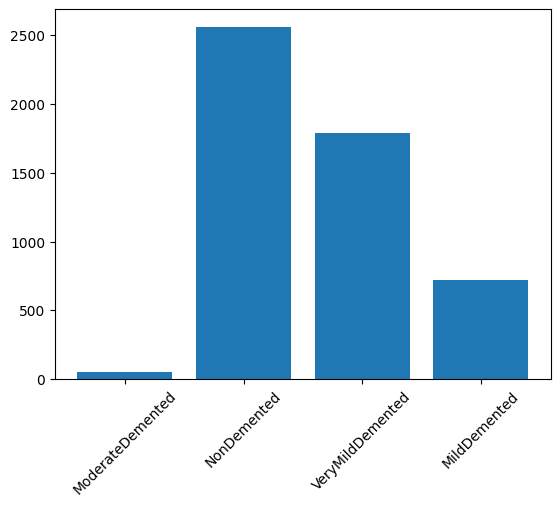

In [8]:
plt.bar(classes, class_distributions.values())
plt.xticks(rotation=45)

In [9]:
from PIL import Image

In [10]:
def get_image_dimensions(image_path):
    image = Image.open(image_path)
    return image.width, image.height

In [11]:
from tqdm import tqdm

In [12]:
class_dimensions_distributions = {
    'width': [],
    'height': [],
    'class': []
}

In [13]:
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        image_width, image_height = get_image_dimensions(image_path)
        class_dimensions_distributions['width'].append(image_width)
        class_dimensions_distributions['height'].append(image_height)
        class_dimensions_distributions['class'].append(class_name)

100%|██████████| 717/717 [00:01<00:00, 684.35it/s]


In [14]:
dimensions_df = pd.DataFrame(class_dimensions_distributions)
dim_df = pd.DataFrame(class_dimensions_distributions)

In [15]:
dimensions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5121 entries, 0 to 5120
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   width   5121 non-null   int64 
 1   height  5121 non-null   int64 
 2   class   5121 non-null   object
dtypes: int64(2), object(1)
memory usage: 120.1+ KB


In [16]:
dimensions_df.describe()

,width,height
count,5121.0,5121.0
mean,176.0,208.0
std,0.0,0.0
min,176.0,208.0
25%,176.0,208.0
50%,176.0,208.0
75%,176.0,208.0
max,176.0,208.0


#### Distribution of photos' dimensions

In [17]:
dimensions_df['width'].value_counts(), dimensions_df['height'].value_counts()

(width
 176    5121
 Name: count, dtype: int64,
 height
 208    5121
 Name: count, dtype: int64)

In [18]:
dimensions_df.shape

(5121, 3)

In [19]:
def image_to_numpy(image_path):
    image = Image.open(image_path)
    return np.array(image)

In [20]:
# setting tensor to store all images' pixels
images = np.empty((5121, 208, 176))
class_to_idx = {}
for i in range(len(classes)):
    class_to_idx[classes[i]] = i
images_labels = np.empty(5121)

In [21]:
image_idx = 0
for class_name in classes:
    for image_name in tqdm(os.listdir(f'{train_base_dir}/{class_name}')):
        image_path = f'{train_base_dir}/{class_name}/{image_name}'
        images[image_idx] = image_to_numpy(image_path)
        images_labels[image_idx] = class_to_idx[class_name]
        image_idx += 1

100%|██████████| 717/717 [00:00<00:00, 1112.54it/s]


In [22]:
import seaborn as sns

#### Displaying heatmap for each class - whiter is weaker density

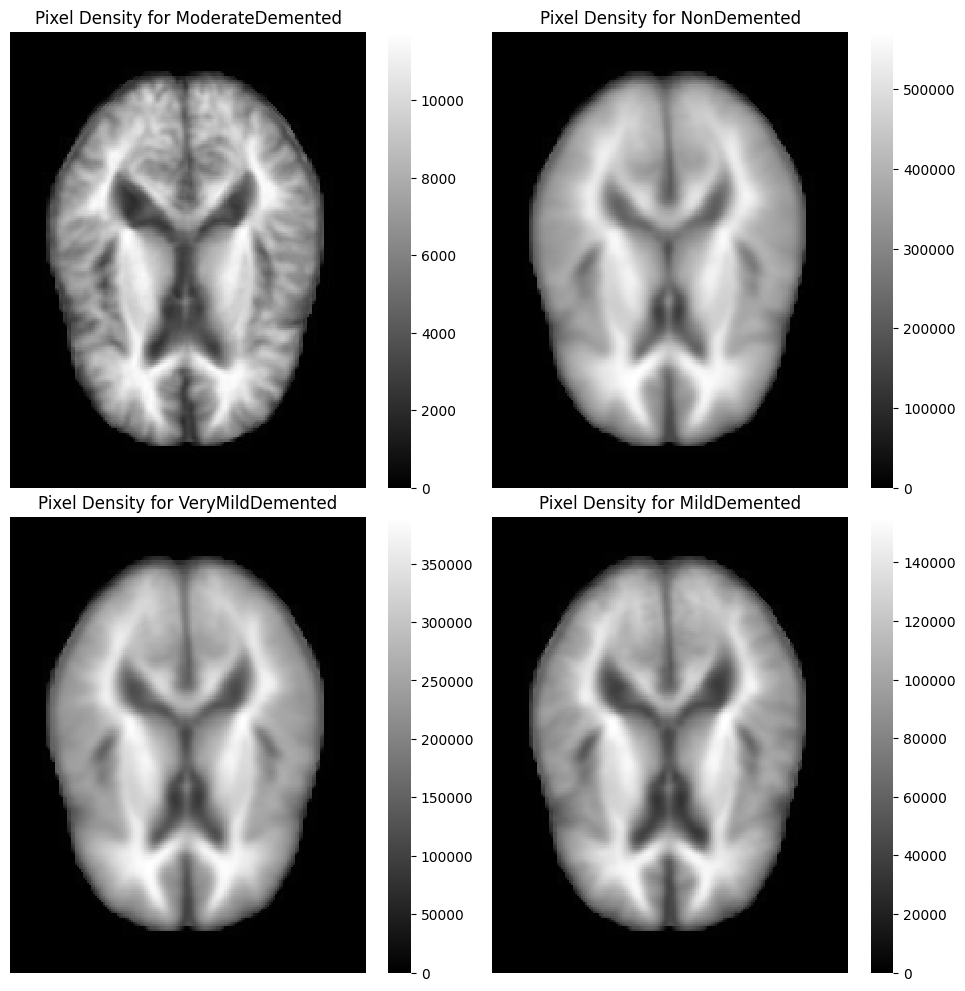

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Pixel Density for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

#### Drop all empty pixels to reduce dimensions

In [24]:
# get leftmost non empty pixel
non_empty_pixels = np.where(images > 0)[1:]

In [25]:
non_empty_pixels

(array([ 16,  16,  16, ..., 191, 191, 191]),
 array([ 88,  89,  90, ..., 117, 118, 119]))

In [26]:
uppermost_pixel = np.min(non_empty_pixels[0])
bottommost_pixel = np.max(non_empty_pixels[0])
leftmost_pixel = np.min(non_empty_pixels[1])
rightmost_pixel = np.max(non_empty_pixels[1])

In [27]:
# top left
leftmost_pixel, uppermost_pixel

(16, 16)

In [28]:
# bottom right
rightmost_pixel, bottommost_pixel

(159, 191)

In [29]:
# dropping
images = images[:, uppermost_pixel:bottommost_pixel+1, leftmost_pixel:rightmost_pixel+1]

In [30]:
images.shape

(5121, 176, 144)

In [31]:
df = pd.DataFrame(images.reshape(images.shape[0], -1))

In [32]:
df.shape

(5121, 25344)

In [33]:
# number of reduced dimensions
208 * 176 - 25344

11264

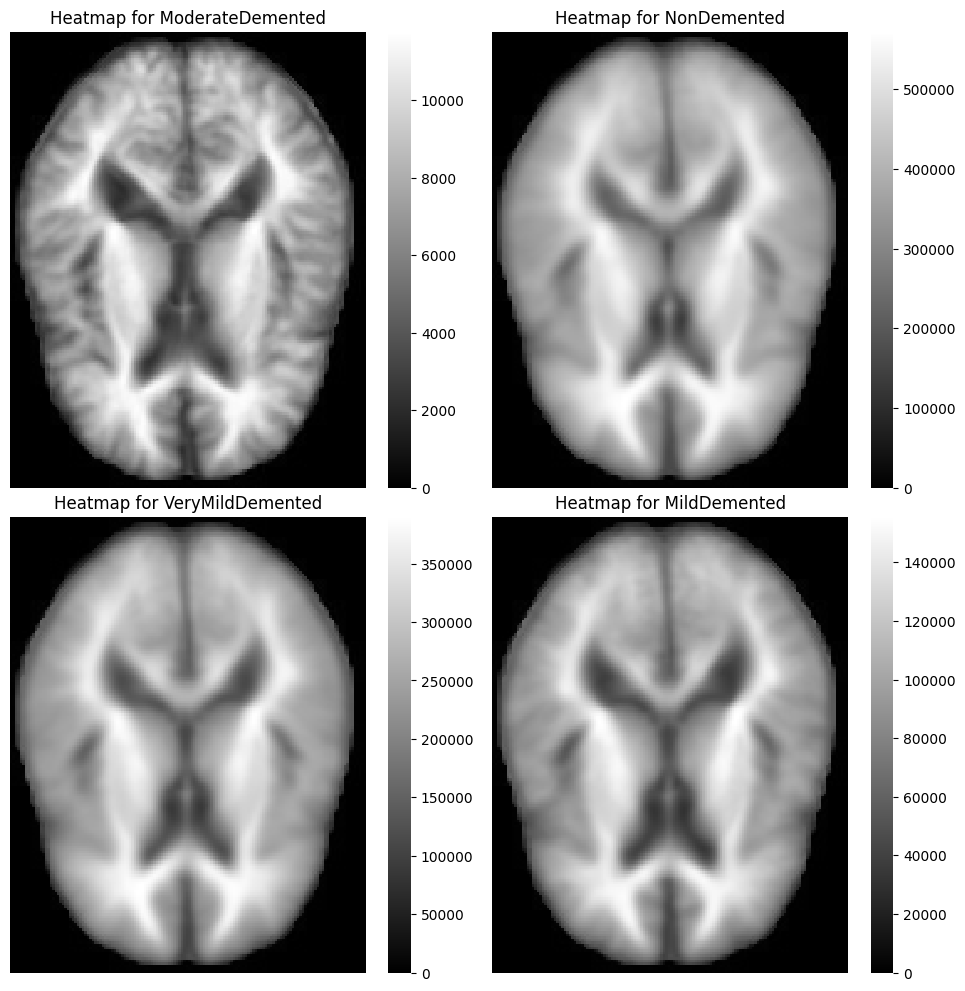

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

for i in range(len(classes)):
    ax = axes[i//2, i%2]
    class_images = images[np.where(images_labels == i)]
    heatmap = np.sum(class_images, axis=0)
    sns.heatmap(heatmap, ax=ax, cmap='gray')
    ax.set_title(f'Heatmap for {classes[i]}')
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

In [35]:
import scipy as sp

In [36]:
def plot_transformed_and_original(transformed_images):
    # plot
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    subfigs = fig.subfigures(2, 2)

    for class_idx, subfig in enumerate(subfigs.flat):
        subfig.suptitle(classes[class_idx])
        axes = subfig.subplots(1, 2)

        blurred_images = transformed_images[np.where(images_labels == class_idx)]
        blurred_heatmap = np.sum(blurred_images, axis=0)
        sns.heatmap(blurred_heatmap, ax=axes[0], cmap='gray')
        axes[0].set_title('Blurred')
        axes[0].get_yaxis().set_visible(False)
        axes[0].get_xaxis().set_visible(False)

        original_images = images[np.where(images_labels == class_idx)]
        original_heatmap = np.sum(original_images, axis=0)
        sns.heatmap(original_heatmap, ax=axes[1], cmap='gray')
        axes[1].set_title('Original')
        axes[1].get_yaxis().set_visible(False)
        axes[1].get_xaxis().set_visible(False)

In [37]:
def apply_filter(filter_func, **kwargs):
    filtered_images = filter_func(images, **kwargs)
    plot_transformed_and_original(filtered_images)

#### Applying median filter with a kernel size of 3x3

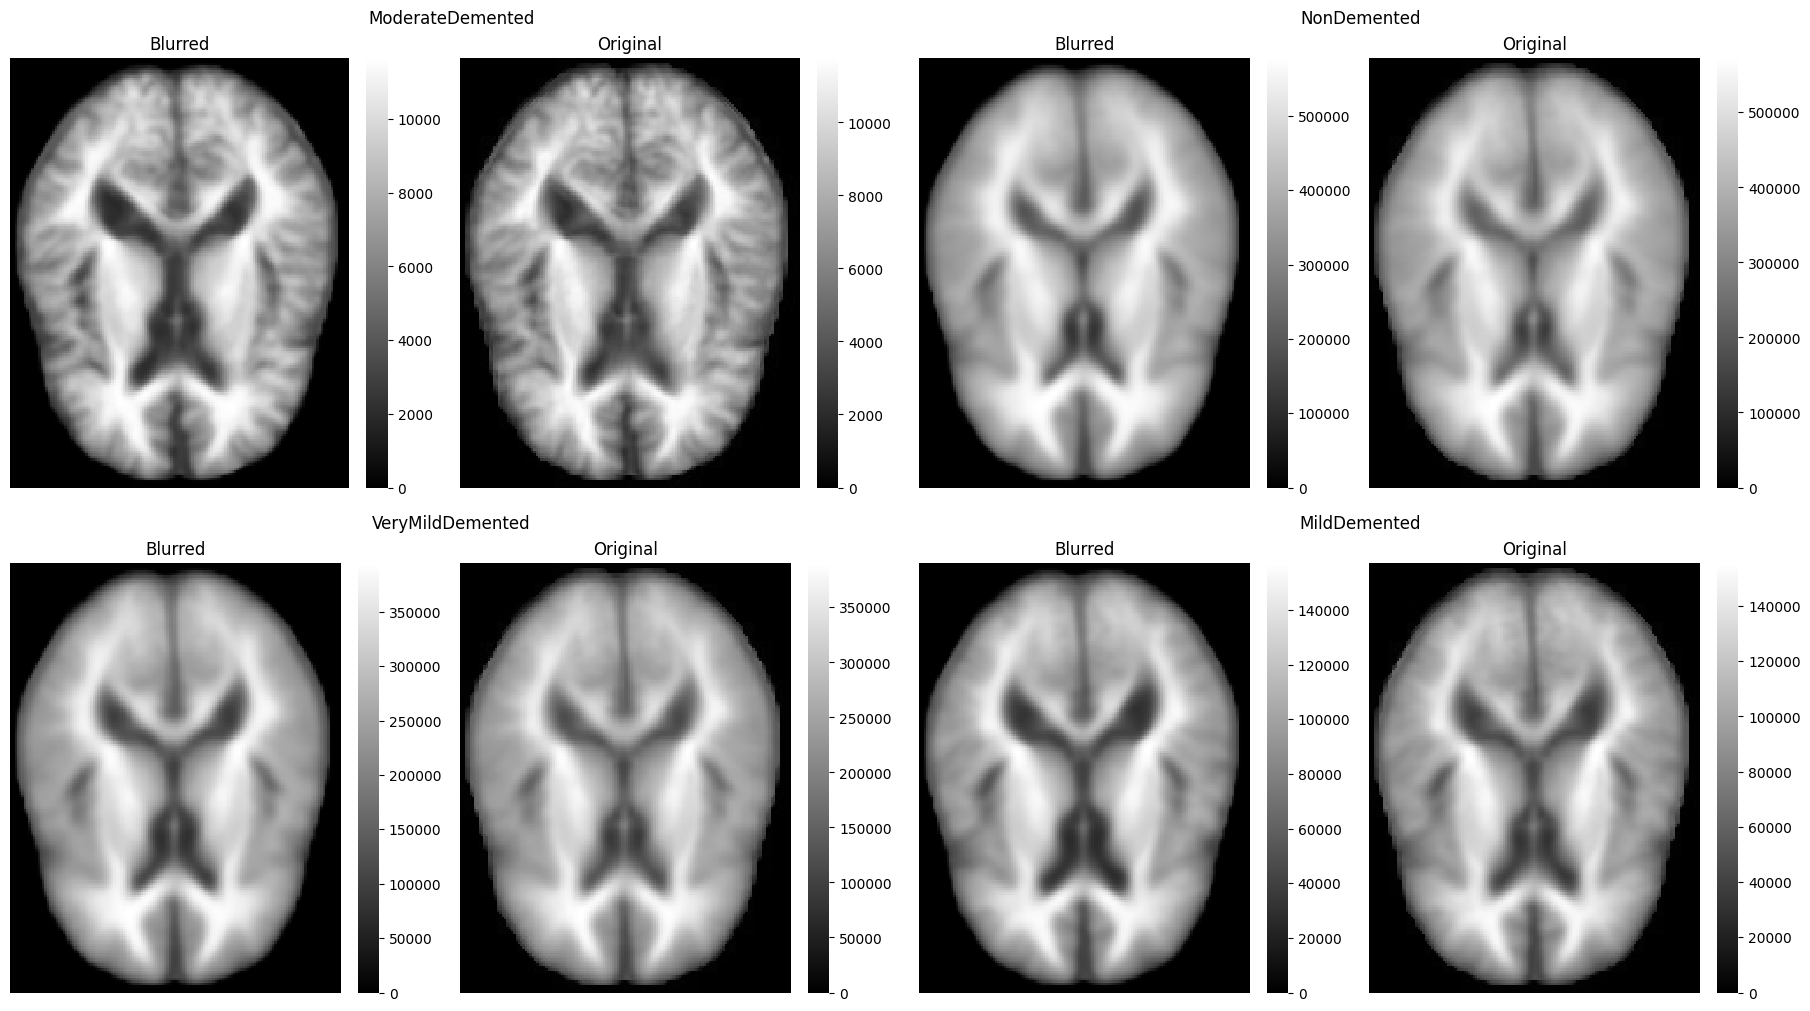

In [38]:
apply_filter(sp.ndimage.median_filter, size=3)

#### Applying max filter with same kernel

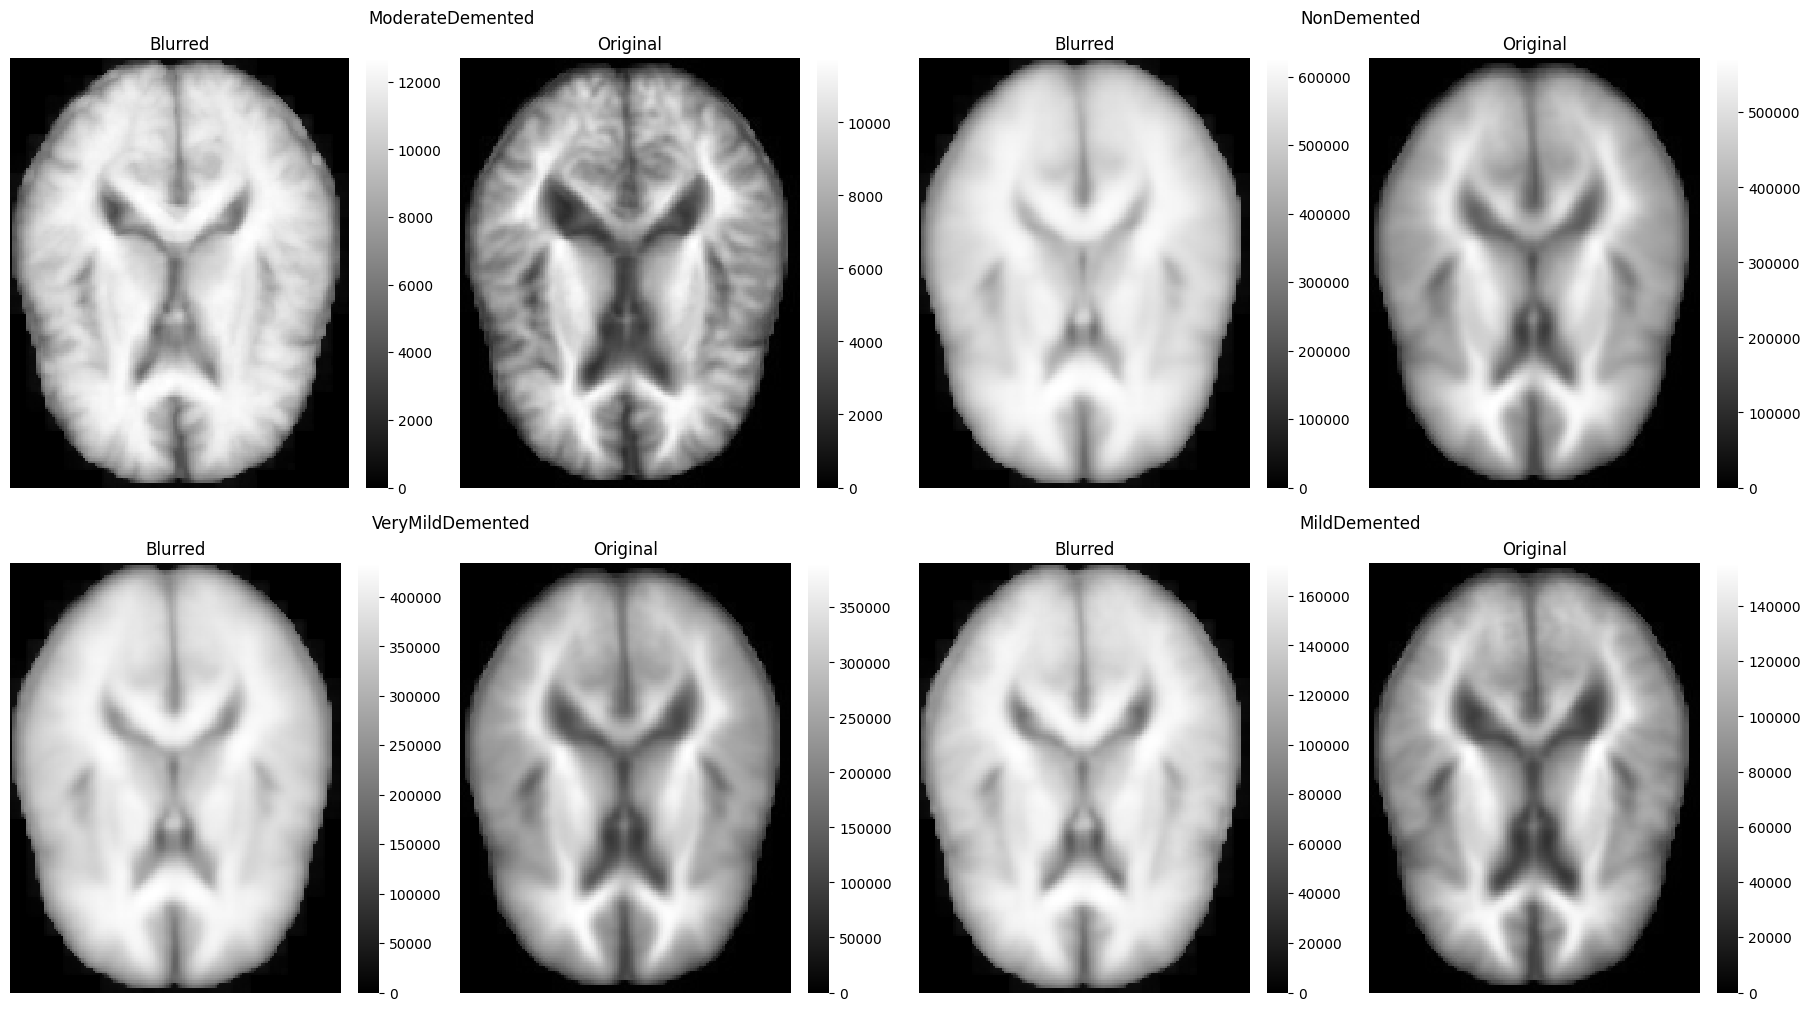

In [39]:
apply_filter(sp.ndimage.maximum_filter, size=3)

#### Minimum filter

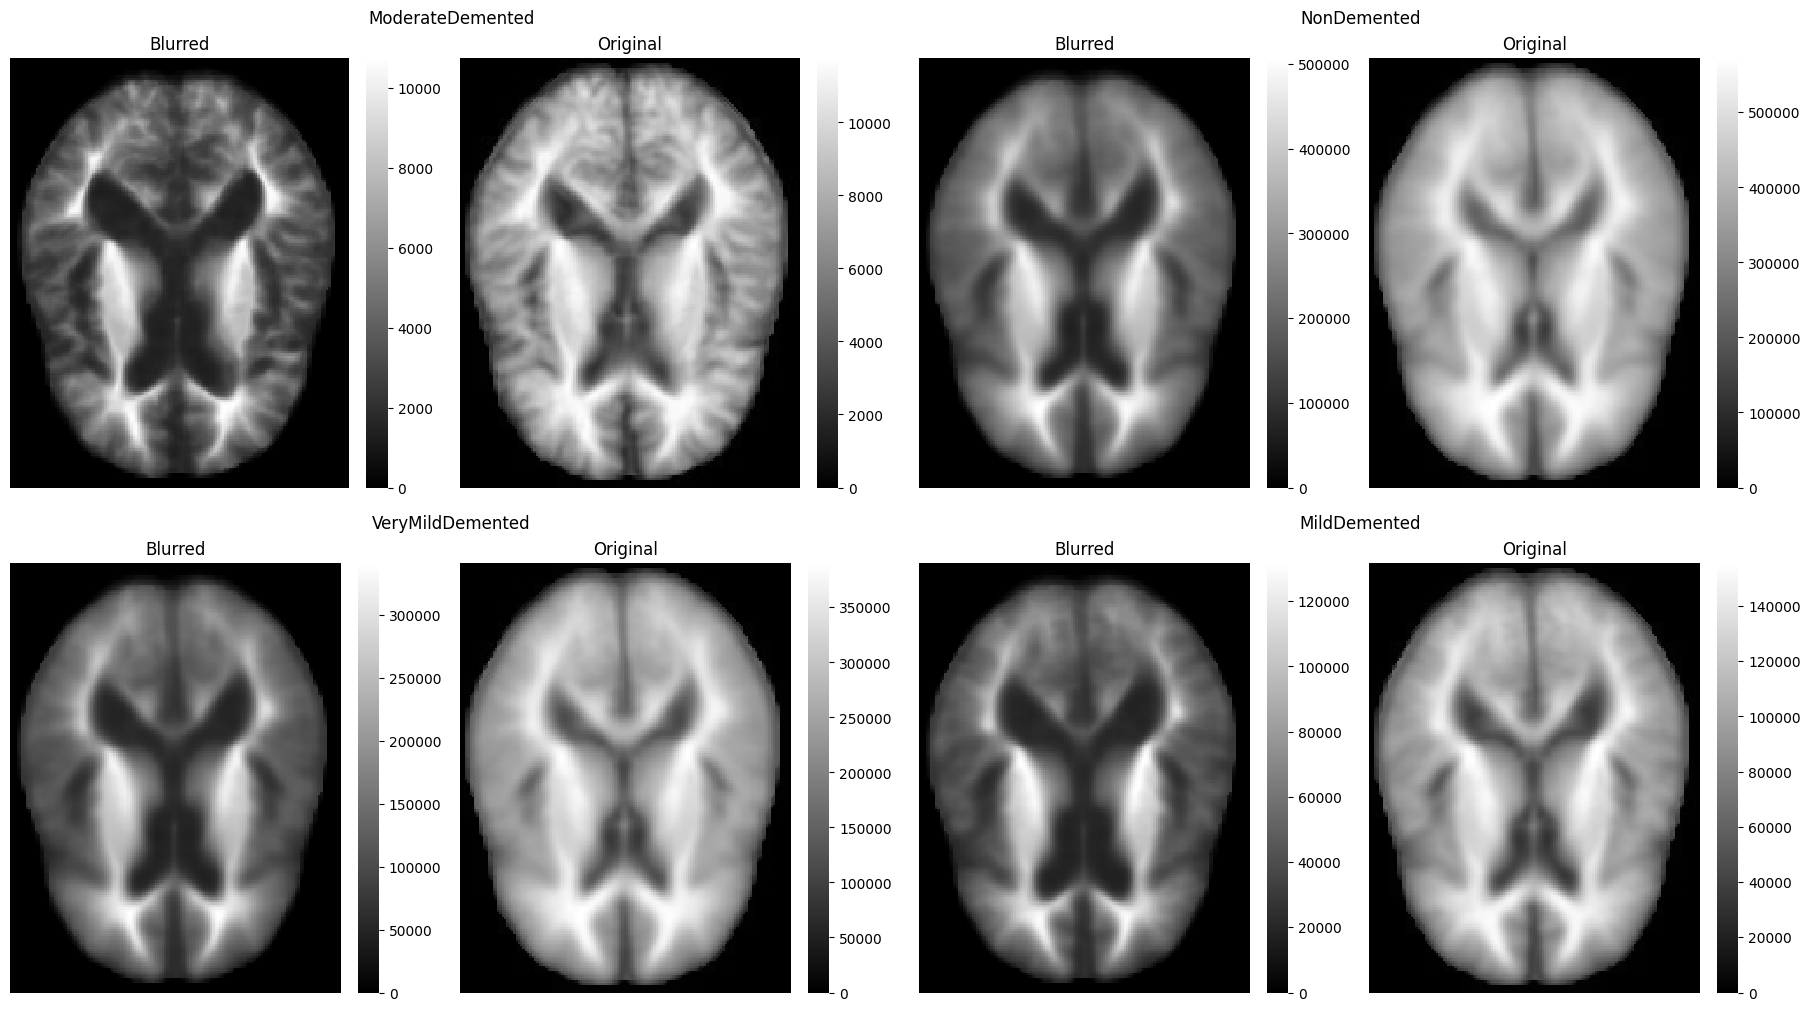

In [40]:
apply_filter(sp.ndimage.minimum_filter, size=3)

#### Sobel filter

In [41]:
sobel_images_x = sp.ndimage.sobel(images, axis=1)
sobel_images_y = sp.ndimage.sobel(images, axis=2)
sobel_images = np.sqrt(sobel_images_x ** 2 + sobel_images_y ** 2)

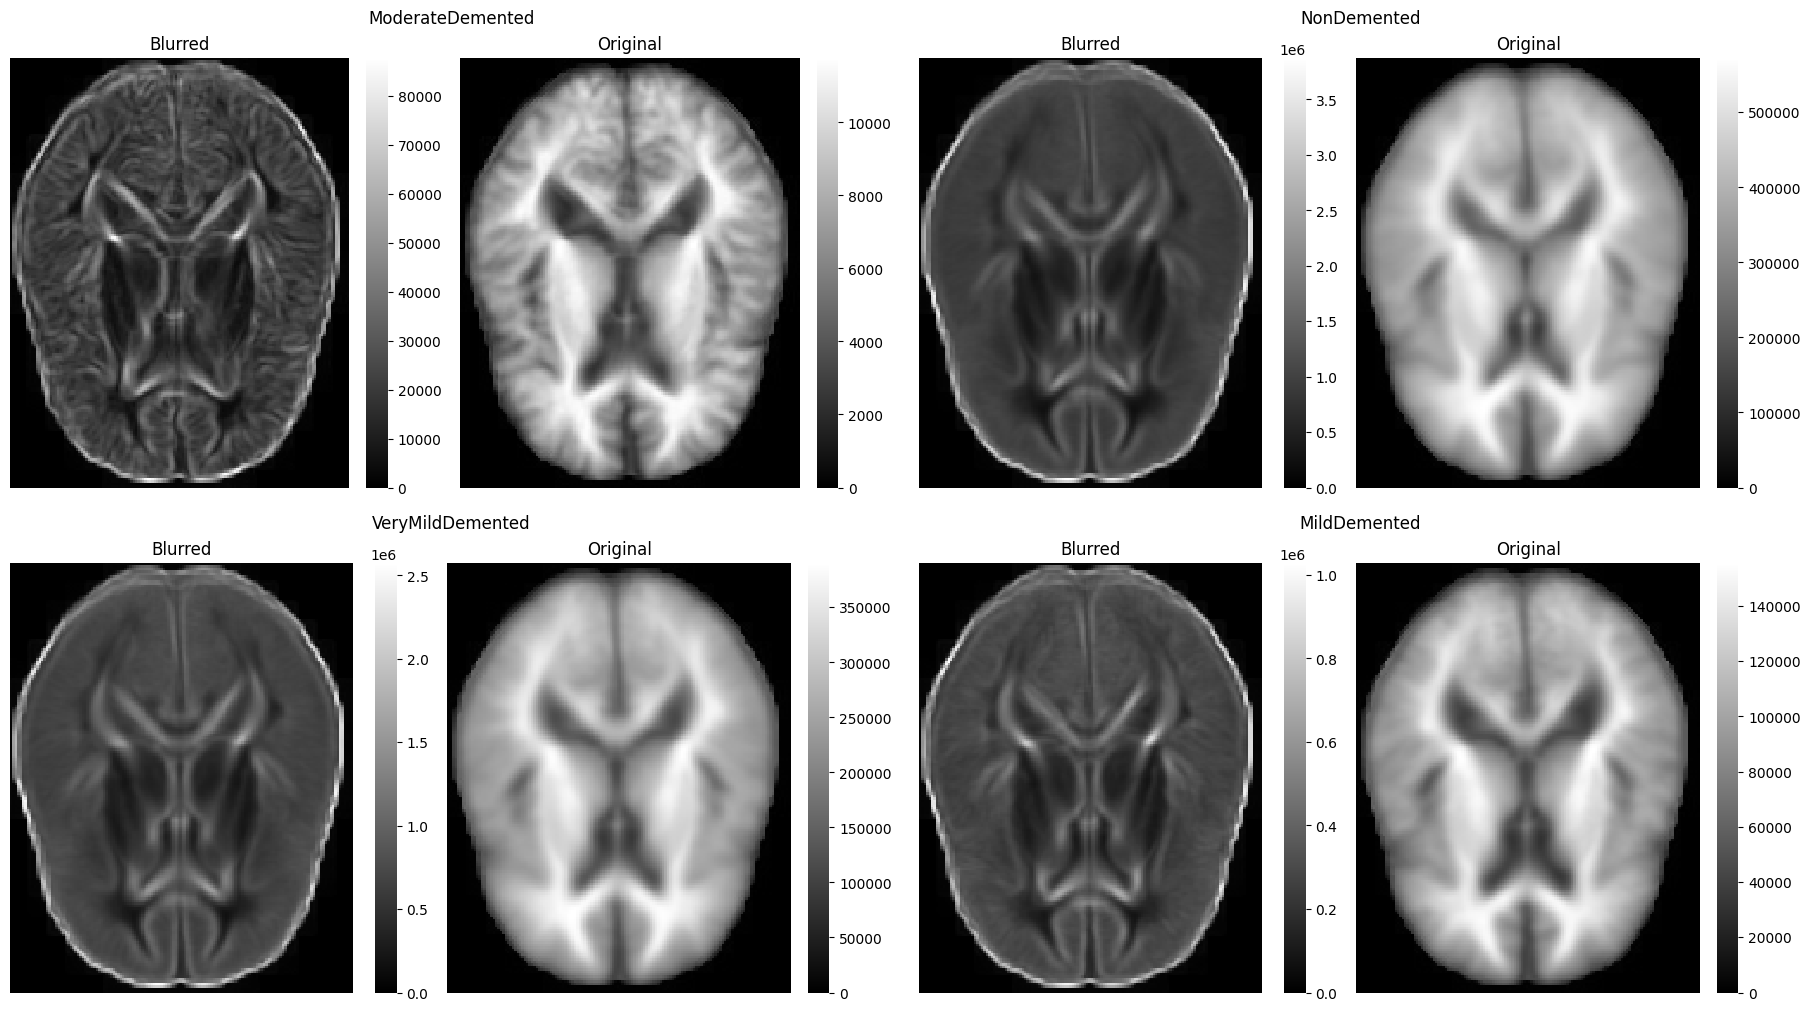

In [42]:
plot_transformed_and_original(sobel_images)

In [43]:
# turning off pixels smaller than their image's mean
greater_than_mean = np.where(images > images.mean(axis=0), 0, images)

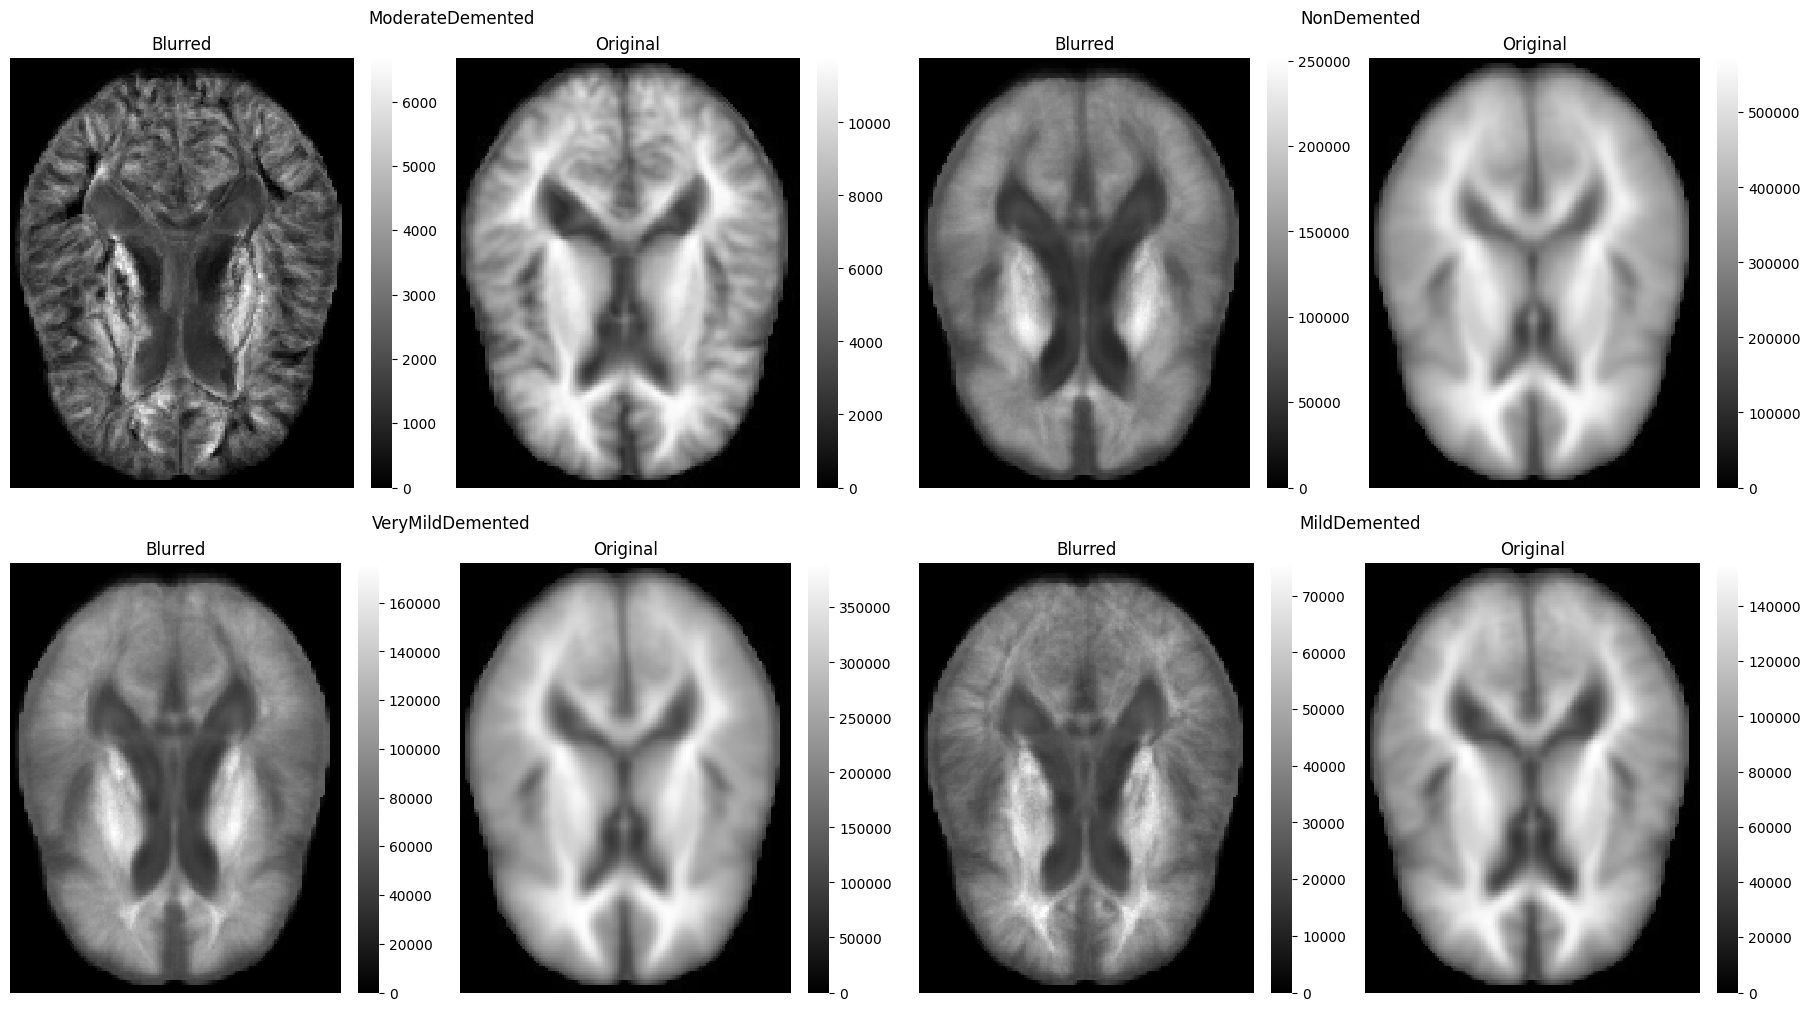

In [44]:
plot_transformed_and_original(greater_than_mean)

### Data Augmentation

#### Training a variational autoencoder for augmenting randomized corrupted data to create new samples
##### Inspired from the following article: https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73

In [45]:
import torch
from torch import nn

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Preparing data for PyTorch

In [47]:
class AlzheimerDataset(torch.utils.data.Dataset):
    def __init__(self, np_images, np_labels, transform=None, target_transform=None):
        # self.X = torch.from_numpy(np_images).to(torch.float32)
        self.X = torch.from_numpy(np_images).to(torch.float32).unsqueeze(dim=1) # adding the single channel
        # self.y = torch.from_numpy(np_labels).to(torch.float32)
        self.y = torch.from_numpy(np_labels)
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        images = self.X[idx]
        labels = self.y[idx]
        if self.transform:
            images = self.transform(images)
        if self.target_transform:
            labels = self.target_transform(labels)
        
        return images, labels

In [48]:
alzheimer_dataset = AlzheimerDataset(images, images_labels)

In [49]:
dataloader = torch.utils.data.DataLoader(alzheimer_dataset, batch_size=256, shuffle=True)

#### Defining encoder and decoder

In [50]:
class ConvEncoder(nn.Module):
    def __init__(self, in_channels, encoded_dim):
        super().__init__()
        
        # non parameterized functionality
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        # initial layers
        self.conv1 = nn.Conv2d(in_channels, 16, kernel_size=(5, 5), 
                               stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.max_indices = None
        self.maxpool = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), 
                                    padding=(1, 1), ceil_mode=False, return_indices=True)
        
        # first residual block
        self.block = nn.Sequential(
            # bias is false as we have a bias in the BN layer
            nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        # down sampling
        self.down_sample1 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
#         self.linear = nn.Linear(in_features=6*437, out_features=encoded_dim, bias=True)
        self.linear = nn.Linear(in_features=32*23*19, out_features=encoded_dim, bias=True)
        
            
    def forward(self, X):
        X0 = self.conv1(X)
        X0 = self.bn1(X0)
        X0 = self.relu(X0)
        X0, self.max_indices = self.maxpool(X0)
        
        # residual block
        Y1_ = self.block(X0)
        Y1_1 = X0 + Y1_
        Y1_1 = self.down_sample1(Y1_1)
        Y2 = self.relu(Y1_1)
        
        Y = self.flatten(Y2)
        Y = self.linear(Y.squeeze())
        
        return Y

In [51]:
class ConvDecoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        
        self.relu = nn.ReLU()
        
#         self.linear = nn.Linear(in_features=encoded_dim, out_features=6*437, bias=True)
        self.linear = nn.Linear(in_features=encoded_dim, out_features=32*23*19, bias=True)
        # reshape to 6x437 before passing through this block
        self.up_sample1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=2, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        
        self.max_indices = None
        self.max_unpool = nn.MaxUnpool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.conv_transpose1 = nn.ConvTranspose2d(16, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        self.bn1 = nn.BatchNorm2d(1)
        
        
    def set_max_indices(self, max_indices):
        self.max_indices = max_indices
    
    def forward(self, X):
        X0 = self.linear(X)
        # reshaping to (batch, channels, pixels) shape
        X0 = X0.reshape(-1, 32, 23, 19)
        X0 = self.relu(X0)
        
        Y1 = self.up_sample1(X0)
        Y1_1 = self.block(Y1)
        Y2 = Y1 + Y1_1 
        
        Y = self.max_unpool(Y2, self.max_indices)
        Y = self.conv_transpose1(Y)
        Y = self.bn1(Y)
        Y = self.relu(Y)
        # remove last row and column in the image
        Y = Y[..., :-1, :-1]
        # print(Y.shape)
        
        return Y

In [67]:
class AutoEncoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        # latent space is 2, i.e: encoding to a 2d space
        self.encoder = ConvEncoder(1, encoded_dim)
        self.decoder = ConvDecoder(encoded_dim)

    def forward(self, X):
        x = self.encoder(X)
        self.decoder.set_max_indices(self.encoder.max_indices)
        x = self.decoder(x)
        
        return x

In [68]:
autoencoder = AutoEncoder(176)
encoder = autoencoder.encoder
decoder = autoencoder.decoder

In [69]:
sum(p.numel() for p in autoencoder.parameters())

4956018

In [70]:
lr = 0.01
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, betas=(0.99, 0.99))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
loss = nn.MSELoss()

In [71]:
autoencoder.to(device)

AutoEncoder(
  (encoder): ConvEncoder(
    (relu): ReLU()
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=1, ceil_mode=False)
    (block): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
    (down_sample1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=T

In [72]:
epochs = 75
losses = torch.zeros(epochs)

In [73]:
for epoch in tqdm(range(epochs)):
    autoencoder.train()
    for batch_idx, (batch_X, _) in enumerate(dataloader):
        batch_X = batch_X.to(device=device)
        optimizer.zero_grad()
        batch_output = autoencoder(batch_X)
        batch_loss = loss(batch_output, batch_X)
        batch_loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        # print('Evaluating model...')
        autoencoder.eval()
        output = autoencoder(alzheimer_dataset.X.to(device))
        output_loss = loss(output, alzheimer_dataset.X.to(device))
        losses[epoch] = output_loss.item()

100%|██████████| 75/75 [04:01<00:00,  3.22s/it]


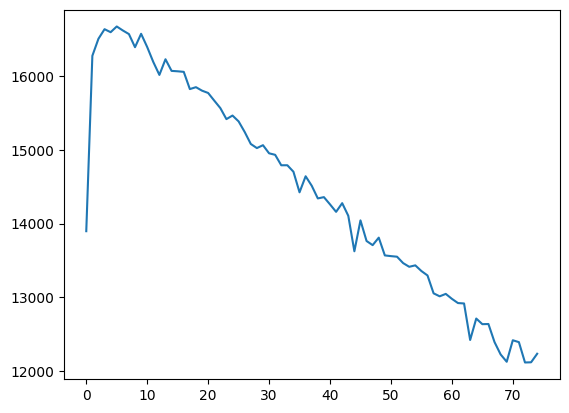

In [74]:
plt.plot(losses.cpu())

In [75]:
maximum_images = sp.ndimage.maximum_filter(images, size=3)
single_channel_images = np.expand_dims(images, axis=1)
single_channel_images.shape

(5121, 1, 176, 144)

In [76]:
# getting a generated image from the original
with torch.no_grad():
    # expanding the channel
    original_batched_image = np.expand_dims(images[0], axis=0)
    # expanding batch
    original_batched_image = np.expand_dims(original_batched_image, axis=0)
    generated_image = autoencoder(torch.from_numpy(original_batched_image) \
                                  .to(device=device, dtype=torch.float32)) \
                                  .flatten(start_dim=0, end_dim=2)
    print(generated_image.shape)

torch.Size([176, 144])


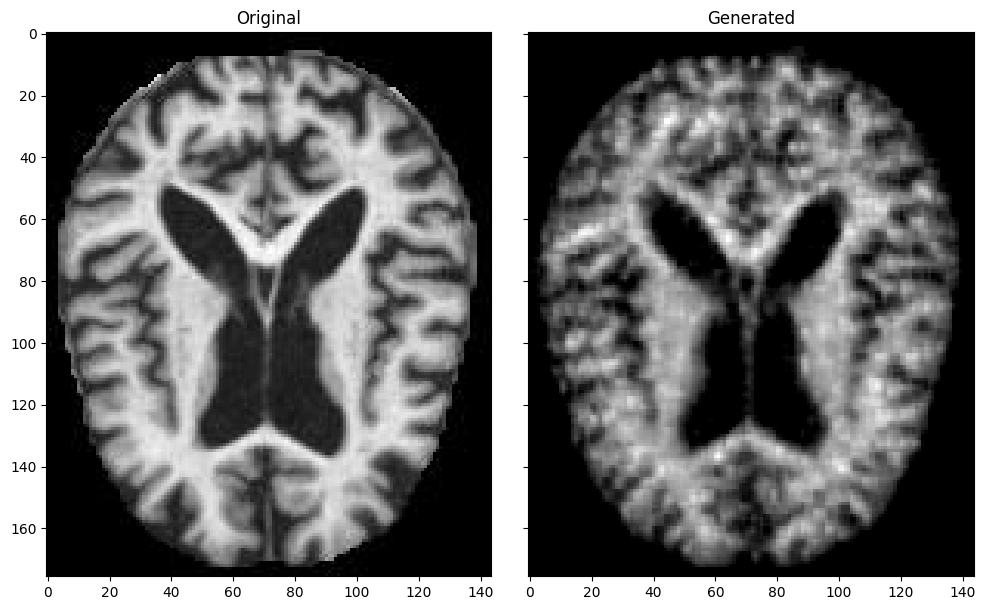

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.tight_layout()

axes[0].set_title('Original')
axes[0].imshow(images[0], cmap='gray')
axes[1].set_title('Generated')
axes[1].imshow(generated_image.cpu(), cmap='gray')

In [78]:
with torch.no_grad():
    encoded_images = encoder(torch.from_numpy(single_channel_images).to(device=device, dtype=torch.float32)).cpu()

In [79]:
encoded_images.shape

torch.Size([5121, 176])

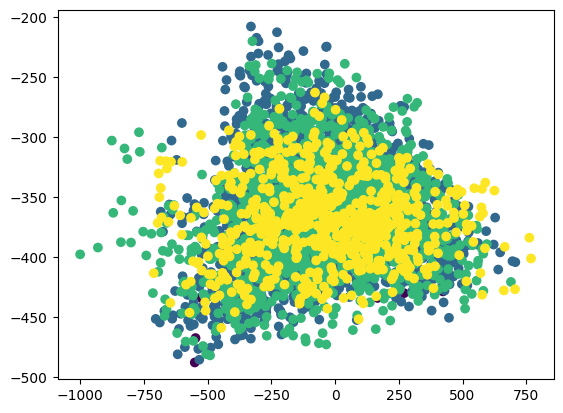

In [80]:
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=images_labels)

In [81]:
with torch.no_grad():
    plt.imshow(decoder(torch.tensor([[[0, 500]]]).to(device, torch.float32).detach()).cpu().squeeze().numpy(), cmap='gray')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 176x13984)